In [20]:
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors
from collections import OrderedDict

colors = mcolors.CSS4_COLORS
import random

In [21]:
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import gzip
import json
import csv
import re
import pandas as pd
import numpy as np
from tqdm import tqdm 

def parse_name(name):
  name = name.lower()
  name = re.sub(r'[0-9]*', '', name)
  if 'loss' in name or 'entropy' in name:
    return 'Others'
  elif 'optimizer' in name or 'update' in name or 'adam' in name:
    return 'OPT'
  elif 'layernorm' in name or 'layer_norm' in name or 'norm' in name:
    return 'LN+Dropout'
  elif 'batchnorm' in name or 'batch_norm' in name or 'relu' in name:
    return 'BN+ReLU'
  # elif 'cast' in name:
  #   return 'Fusion(Cast)'
  elif 'dropout' in name and 'self' in name or '/type_embeddings/matmul' in name:
    return 'Softmax+Dropout'
    
  elif 'dropout' in name :
    return 'LN+Dropout'
  elif 'relu' in name:
    return 'Fusion(ReLU)'
  elif 'softmax' in name:
    return 'Softmax+Dropout'
  return 'Fusion'

def find_kernel_metadata(name, hlo_file_name):
  if len(name.split('_')) == 1:
    return name
  name = name.replace('_', '.') + ' '
  with open(hlo_file_name, 'r') as f:
    for line in f.readlines():
      if name in line:
        find_meta = line.split('metadata')
        if len(find_meta) > 1 and len(find_meta[1].split('\"')) > 3:
          name1 =find_meta[1].split('\"')[3]
          name1 = parse_name(name1)
#           if name1 == 'Fusion':
#             print(name, find_meta[1].split('\"')[3])
          return name1
    return 'Fusion'

namespace = ['CONV+BN+ELEMWISE', 'NDP_OP', 'BN+ELEMWISE', 'CONV', 'FC', 'POOLING', 'dxCONV', 'dwCONV', 'dxFC', 'dwFC', 'OPT',\
        'Fusion(Loss)', 'Fusion(Optimizer)', 'Fusion(LayerNorm)','Fusion(BatchNorm)', 'Fusion(Cast)', 'Fusion(Dropout)',\
        'Fusion(Einsum)', 'Fusion(BiasAdd)', 'Fusion(Gelu)', 'Fusion(ReLU)', 'Fusion(SelfAttention)', 'BN+ReLU', 'Fusion(Softmax)', 'LayerNorm',
        'GEMM', 'Dropout', 'LN+Dropout', 'Softmax+Dropout']

def group_NDP_kernel_name(name):
  if 'softmax' in name:
    return 'Softmax+Dropout'
  elif 'bert_out' in name:
    return 'LN+Dropout'
  elif 'adam' in name:
    return 'OPT'
  else:
    print("ERROR")
    assert(0)

def group_GPU_kernel_name(name, hlo_path):
  if 'gemm' in name:
    return 'GEMM'
  else:
    opname = find_kernel_metadata(name, hlo_path)
    if not opname in namespace:
      return 'Others'
    return opname

color_map = dict()
color_map['Softmax+Dropout'] = colors['darkorange']
color_map['LN+Dropout'] = colors['orangered']
color_map['OPT'] = colors['forestgreen']
color_map['GEMM'] = colors['royalblue']
color_map['Fusion'] = colors['gold']
color_map['Others'] = colors['dimgrey']

In [22]:
MODEL = 'BERT_large_ndp2_3_b'
BATCH = 3
OUTPUT_DIR = f'./util_plot/{MODEL}{BATCH}'
os.makedirs(OUTPUT_DIR, exist_ok=True)
PERIOD = 10000.0
LINK_FREQ = 1200.0
DRAM_FREQ = 877.0
GPU_FREQ = 1380

Softmax+Dropout
Softmax+Dropout
Softmax+Dropout
Softmax+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
Softmax+Dropout
Softmax+Dropout
Softmax+Dropout
Softmax+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
Softmax+Dropout
Softmax+Dropout
Softmax+Dropout
Softmax+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
LN+Dropout
BW_START 19583.27391304348
19583.27391304348
19622.74420289855
19627.2
19632.263768115943
19638.053623188407
19643.639855072466
19651.25652173913
21117.97608695652
21212.49855072464
21563.738405797103
21571.186956521742
21668.94130434783
21787.02246376812
21791.0847826087
21927.004347826092
21938.52681159421
21944.775362318847
22211.020289855078
22216.55434782609
22221.371739130438
22470.448550724643
28742.911594202902
28770.682608695657
28779.0847826087
28802.148550724643
28808.230434782614
29800.837681159424
29824.0231884058
29830.28768

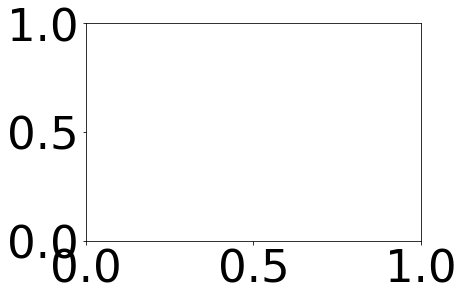

In [23]:
dirs  = open(f'{MODEL}{BATCH}-dir.out')

offset = 0.0
NDPX_MEM_Y = []
NDPX_MEM_Y2 = []
NDPX_MEM_Y3 = []
NDPX_MEM_Y4 = []
NDPX_MEM_X = []
NDPX_LINK_GPU2NDPX = []
NDPX_LINK_NDPX2GPU = []
NDPX_LINK_X = []
started_kernels_GPU = []
started_times_GPU = []
finished_times_GPU = []
started_kernels_NDP = []
started_times_NDP = []
finished_times_NDP = []
started_kernels_NDPX = []
started_times_NDPX = []
finished_times_NDPX = []
backward = False

for dir in dirs.readlines():
    dir = dir.replace('\n', '')
    util_file = open(f'{dir}/GPU_0_Port_0_UTIL.out')
    ndpx_mem_file = open(f'{dir}/NDPX_MEM_ch_3_UTIL.out')
    gpu_mem_file = open(f'{dir}/GPU_MEM_ch_3_UTIL.out')
#     ndpx_mem_file = open(f'{dir}/NDPX_MEM_ch_0_UTIL.out')
    # ndp_name = open(f'{dir}/NDP_name.out').readlines()[0].replace('\n', '')
    # TITLE = f'{dir.split("/")[-1]}-{ndp_name}'
    if not backward and 'backward' in dir:
        print(f'BW_START {offset}')
        backward = True

    if 'backward' in dir:
        print(offset)
    ID=dir.split("/")[-1]
    GPU2NDPX_list = []
    NDPX2GPU_list = []
    NDPX_MEM_list = []
    GPU_MEM_list = []
    GPU_NDP_MEM_list = []
    NDPX_MEM_list2 = []
    for line in util_file.readlines():
        try:
            line = line[line.find('LINK_UTIL'):]
            splited = line.split(' ')
            GPU2NDPX = splited[8]
            NDPX2GPU = splited[15]
            GPU2NDPX_list.append(float(GPU2NDPX))
            NDPX2GPU_list.append(float(NDPX2GPU))
        except:
            print(line)
    for line in ndpx_mem_file.readlines():
        splited = line.split(' ')
        NDPX_MEM_list.append(float(splited[3]) / 100.0)
    for line in gpu_mem_file.readlines():
        splited = line.split(' ')
        # print(float(splited[3]) / 100.0)  
        GPU_MEM_list.append(float(splited[5]) / 100.0)   
        GPU_NDP_MEM_list.append(float(splited[8]) / 100.0)
        NDPX_MEM_list.append(float(splited[11]) / 100.0)  
        NDPX_MEM_list2.append(float(0 / 100.0))

#     for line in  ndpx_mem_file.readlines():
#         splited = line.split(' ')
#         NDPX_MEM_list2.append(float(splited[3]) / 100.0)
    min_len = min(len(GPU_MEM_list), len(GPU_NDP_MEM_list), len(NDPX_MEM_list), len(NDPX_MEM_list2))
#     min_len = min(len(GPU_MEM_list), len(GPU_NDP_MEM_list), len(NDPX_MEM_list))
    GPU_MEM_list = GPU_MEM_list[:min_len]
    GPU_NDP_MEM_list = GPU_NDP_MEM_list[:min_len]
    NDPX_MEM_list = NDPX_MEM_list[:min_len]
    NDPX_MEM_list2 = NDPX_MEM_list2[:min_len]

    Link_X = range(0, len(GPU2NDPX_list))
    Link_X = list(map(lambda x: float(x) * PERIOD / LINK_FREQ + offset, Link_X))
    MEM_X = range(0, len(GPU_MEM_list))
    MEM_X = list(map(lambda x: float(x) * PERIOD / DRAM_FREQ + offset, MEM_X))
    NDPX_MEM_Y+=(GPU_MEM_list)
    NDPX_MEM_X+=(MEM_X)
    NDPX_MEM_Y2+=(GPU_NDP_MEM_list)
    NDPX_MEM_Y3+=(NDPX_MEM_list)
    NDPX_MEM_Y4+=(NDPX_MEM_list2)
    NDPX_LINK_X += Link_X
    NDPX_LINK_GPU2NDPX += GPU2NDPX_list
    NDPX_LINK_NDPX2GPU += NDPX2GPU_list
    gantt_info = open(f'{dir}/Gantt.out', 'r')
    gantt_info_lines = gantt_info.readlines()
    gantt_info.close()
    for line in gantt_info_lines:
        line = (line[line.find('Gantt'):])
        words = line.split(' ')
        dev = words[5]
        if len(words) == 11:
            # print('GPU: ', words)
            if dev == 'NDP':
                kernel_name = group_NDP_kernel_name(words[8])
                cycle = (float(words[11]) / GPU_FREQ)  + offset
            else:
                kernel_name = group_GPU_kernel_name(words[7],   
                    f'/home/shared/CXL_memory_buffer2/BERT_NDP/traces/{MODEL}{BATCH}/hlo_graph/{MODEL}{BATCH}.txt')
                cycle = (float(words[10]) / GPU_FREQ) + offset
            if words[4] == 'launched':
                # print(words)

                if dev == 'gpu':
                    started_kernels_GPU.append(kernel_name)
                    started_times_GPU.append(cycle)
                else:
                    assert(0)
            else:
                if dev == 'gpu':
                    finished_times_GPU.append(cycle)
                else:
                    assert(0)
        else:
            kernel_name = group_NDP_kernel_name(words[8])
            cycle = (float(words[11]) / GPU_FREQ)  + offset
            # print('OPT: ', words)

            if words[4] == 'launched':
                if dev == 'NDP' and not 'OPT' in kernel_name:
                    started_kernels_NDP.append(kernel_name)
                    started_times_NDP.append(cycle)
                    print(kernel_name)
                elif 'OPT' in kernel_name:
                    started_kernels_NDPX.append(kernel_name)
                    started_times_NDPX.append(cycle)
                else:
                    print(words)
            else:
                if dev == 'NDP' and not 'OPT' in kernel_name:
                    finished_times_NDP.append(cycle)
                elif 'OPT' in kernel_name:
                    finished_times_NDPX.append(cycle)

    
    
    offset = max(max(finished_times_GPU, default=0), max(finished_times_NDP,default=0), max(finished_times_NDPX, default=0))
    # print(offset)

#     plt.plot(Link_X, GPU2NDPX_list, label='GPU to NDPX')
#     plt.plot(Link_X, NDPX2GPU_list, label='NDPX to GPU')
# plt.subplot(2,1,1)
# plt.plot(NDPX_MEM_X, NDPX_MEM_Y, label="NDP")

#     plt.plot(MEM_X, NDPX_MEM_list, label='NDPX memory util')
# plt.legend(loc='upper left', ncol=4)
# plt.ylim(0, 100)
# plt.ylabel('Utilization (%)')
# plt.xlabel('Time (us)')
# plt.title("UTIL")
# plt.subplot(2,1,2)
# colors2 = list(colors.values())

# i = 0
# for name, start, end in zip(started_kernels_GPU, started_times_GPU, finished_times_GPU):
#     plt.broken_barh([(start, end-start)],(2, 1), facecolors=color_map[name], label=name)
#     i+=1
# for name, start, end in zip(started_kernels_NDP, started_times_NDP, finished_times_NDP):
#     plt.broken_barh([(start, end-start)],(1, 1), facecolors=color_map[name], label=name)
#     i+=1

# plt.legend(loc='upper left', ncol=4)
# plt.broken_barh([(started_times_GPU[ii], finished_times_GPU[ii])],(6, 1), facecolors=, label=name)
#  plt.savefig(f'{OUTPUT_DIR}/UTIL.png', format='png')
plt.cla()
print(len(NDPX_MEM_Y), len(NDPX_MEM_Y2), len(NDPX_MEM_Y3), len(NDPX_MEM_Y4))
print(offset)

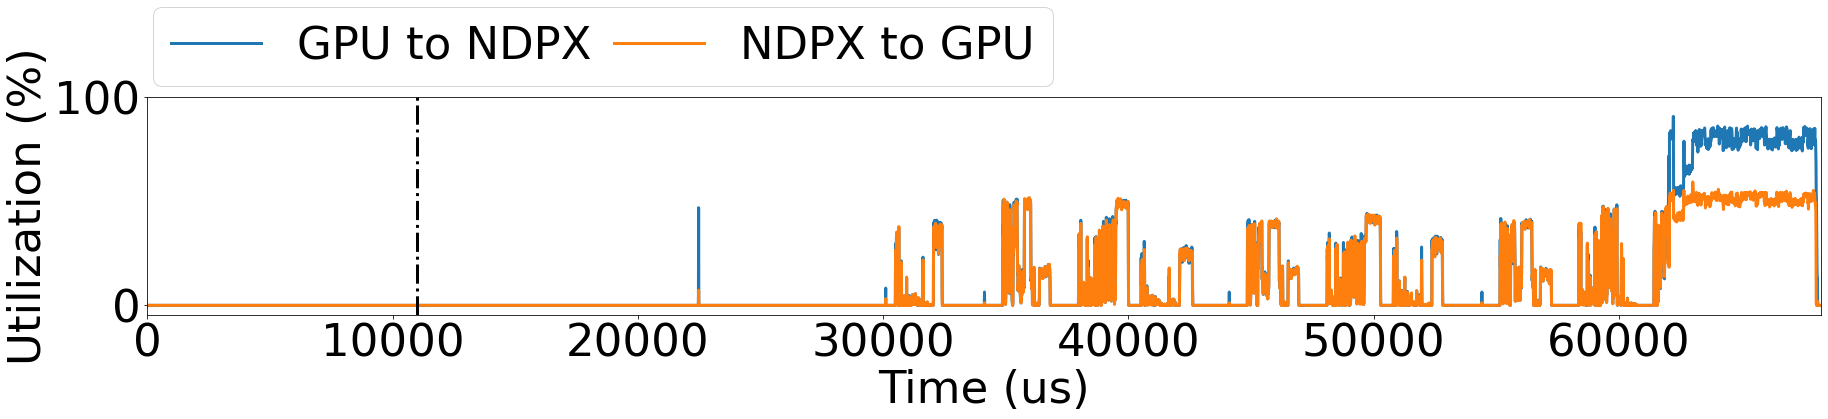

In [24]:
plt.figure(figsize=(30,4))
plt.plot(NDPX_LINK_X, NDPX_LINK_GPU2NDPX, linewidth=3,label='GPU to NDPX')
plt.plot(NDPX_LINK_X, NDPX_LINK_NDPX2GPU, linewidth=3, label='NDPX to GPU')
plt.legend(loc='upper left', ncol=2 , bbox_to_anchor=(-0.01, 1.52), columnspacing=0.5)
plt.ylabel('Utilization (%)')
plt.xlabel('Time (us)')
plt.ylim(top=100)
plt.xlim(left=0, right=max(NDPX_LINK_X))
plt.axvline(x=10975.642028985501, color='k', linestyle='-.', linewidth=3, label='G+N+X backard start')
plt.savefig('Link_Util_Plot.pdf', bbox_inches="tight")


In [25]:
MODEL = 'BERT_large_3_b'

BATCH = 3
# OUTPUT_DIR = f'./util_plot/{MODEL}{BATCH}-TRY-1'
OUTPUT_DIR = f'./util_plot/{MODEL}{BATCH}'
os.makedirs(OUTPUT_DIR, exist_ok=True)
PERIOD = 10000.0
LINK_FREQ = 1200.0
DRAM_FREQ = 877.0
GPU_FREQ = 1380

In [26]:
avg_range = 10
def BW_averaging(bw_list):
  for i in range(len(bw_list) // avg_range):
    if i*avg_range+avg_range < len(bw_list):
      offset = avg_range
    else :
      offset = len(bw_list - i*avg_range)
    avg = sum(bw_list[i*avg_range: i*avg_range+offset]) / offset
    for j in range(offset):
      bw_list[i*avg_range + j] = avg
  return bw_list


5909 6969
[(22475.483333333337, 0.7340579710144084), (22475.483333333337, 4.37028985507277), (30108.009420289854, 0.7253623188407801), (30108.009420289854, 1.262318840581429), (30108.735507246376, 0.6847826086959685), (30109.271739130436, 0.5340579710136808), (30109.421014492753, 0.5159420289855916), (30509.253623188404, 1898.8789855072464), (30509.254347826085, 1898.9210144927529), (32408.13333333333, 1.0253623188400525), (32408.175362318838, 1.0601449275382038), (32409.159420289852, 0.8115942028998688), (34135.1347826087, 1.159420289855916), (34875.87681159421, 0.8579710144913406), (34875.877536231885, 2.8702898550764075), (34876.7347826087, 4.030434782609518), (34878.74782608696, 1153.5985507246369), (36032.348550724644, 784.7398550724611), (37977.65869565218, 1528.0753623188357), (37977.659420289856, 1531.163768115941), (39505.734057971014, 502.0275362318862), (40007.76376811595, 2.4043478260864504), (40007.76376811595, 2.414492753618106), (40523.50507246378, 2098.3369565217363), (

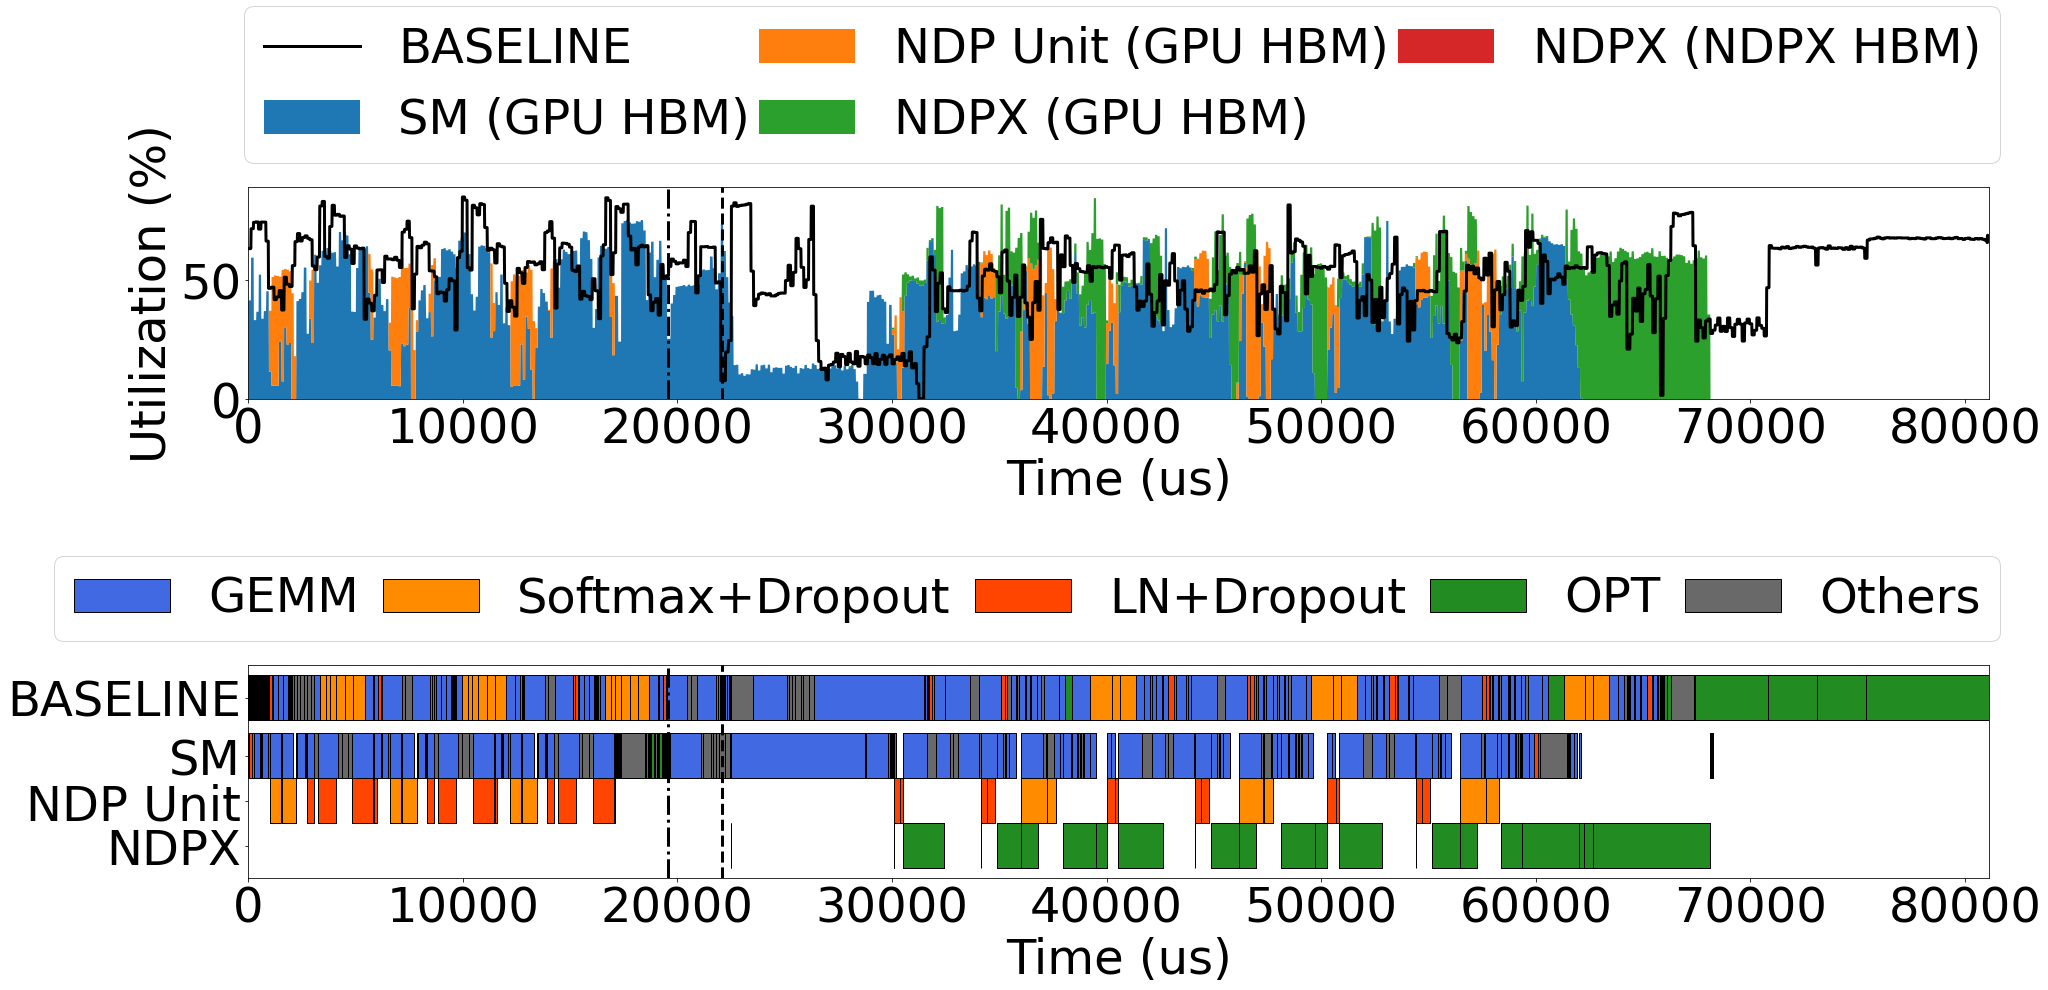

In [27]:
import matplotlib
# dirs  = open(f'../../BERT_BASELINE/scripts/{MODEL}{BATCH}-TRY-1-dir.out')
dirs  = open(f'../../BERT_BASELINE/scripts/{MODEL}{BATCH}-dir.out')

# plt.rcParams["figure.figsize"] = (100,10)
offset = 0.0
BASE_MEM_Y = []
BASE_MEM_X = []
started_kernels_BASE = []
started_times_BASE = []
finished_times_BASE = []
plt.figure(figsize=(30,15))
matplotlib.rcParams.update({'font.size': 48, 'font.weight': 'medium'})
for dir in dirs.readlines():
    dir = dir.replace('\n', '')
#     util_file = open(f'{dir}/GPU_0_Port_0_UTIL.out')
#     ndpx_mem_file = open(f'{dir}/NDPX_MEM_ch_0_UTIL.out')
    gpu_mem_file = open(f'../../BERT_BASELINE/scripts/{dir}/GPU_MEM_ch_0_UTIL.out')

    # ndp_name = open(f'{dir}/NDP_name.out').readlines()[0].replace('\n', '')
    # TITLE = f'{dir.split("/")[-1]}-{ndp_name}'
    ID=dir.split("/")[-1]
    GPU2NDPX_list = []
    NDPX2GPU_list = []
    NDPX_MEM_list = []
    GPU_MEM_list = []
#     for line in util_file.readlines():
#         splited = line.split(' ')
#         GPU2NDPX = splited[8]
#         NDPX2GPU = splited[15]
#         GPU2NDPX_list.append(float(GPU2NDPX))
#         NDPX2GPU_list.append(float(NDPX2GPU))
#     for line in ndpx_mem_file.readlines():
#         splited = line.split(' ')
#         NDPX_MEM_list.append(float(splited[3]) / 100.0)
    for line in gpu_mem_file.readlines():
        try:
            splited = line.split(' ')
            GPU_MEM_list.append(float(splited[3]) / 100.0)   
        except:
            print(dir)
            print(splited)
    Link_X = range(0, len(GPU2NDPX_list))
    Link_X = list(map(lambda x: float(x) * PERIOD / LINK_FREQ + offset, Link_X))
    MEM_X = range(0, len(GPU_MEM_list))
    MEM_X = list(map(lambda x: float(x) * PERIOD / DRAM_FREQ + offset, MEM_X))
    BASE_MEM_Y+=(GPU_MEM_list)
    BASE_MEM_X+=(MEM_X)
    
    gantt_info = open(f'../../BERT_BASELINE/scripts/{dir}/Gantt.out', 'r')
    gantt_info_lines = gantt_info.readlines()
    gantt_info.close()
    for line in gantt_info_lines:
        words = line.split(' ')
  
        dev = words[5]
        if dev == 'NDP':
            kernel_name = group_NDP_kernel_name(words[8])
            cycle = (float(words[11]) / GPU_FREQ)  + offset
        else:
            # kernel_name = group_GPU_kernel_name(words[7],   
                # f'/home/shared/CXL_memory_buffer2/BERT_BASELINE/traces/{MODEL}{BATCH}-TRY-1/hlo_graph/{MODEL}{BATCH}-TRY-1.txt')
            kernel_name = group_GPU_kernel_name(words[7],   
                f'/home/shared/CXL_memory_buffer2/BERT_BASELINE/traces/{MODEL}{BATCH}/hlo_graph/{MODEL}{BATCH}.txt')
            cycle = (float(words[10]) / GPU_FREQ) + offset
        
        if words[4] == 'launched':
            started_kernels_BASE.append(kernel_name)
            started_times_BASE.append(cycle)
        else:
            finished_times_BASE.append(cycle)
    offset = finished_times_BASE[-1]
    
#     plt.plot(Link_X, GPU2NDPX_list, label='GPU to NDPX')
#     plt.plot(Link_X, NDPX2GPU_list, label='NDPX to GPU')
print(len(NDPX_MEM_X), len(BASE_MEM_X))

smooded_NDPX_MEM_Y = BW_averaging(NDPX_MEM_Y)
smooded_NDPX_MEM_Y2 = BW_averaging(NDPX_MEM_Y2)
smooded_NDPX_MEM_Y3 = BW_averaging(NDPX_MEM_Y3)
smooded_NDPX_MEM_Y4 = BW_averaging(NDPX_MEM_Y4)
smooded_BASE_MEM_Y = BW_averaging(BASE_MEM_Y)

# smooded_NDPX_MEM_Y = gaussian_filter1d(NDPX_MEM_Y, sigma=10)
# smooded_NDPX_MEM_Y2 = gaussian_filter1d(NDPX_MEM_Y2, sigma=10)
# smooded_NDPX_MEM_Y3 = gaussian_filter1d(NDPX_MEM_Y3, sigma=10)
# smooded_NDPX_MEM_Y4 = gaussian_filter1d(NDPX_MEM_Y4, sigma=10)
# smooded_BASE_MEM_Y = gaussian_filter1d(BASE_MEM_Y, sigma=10)


plt.tight_layout()


# plt.subplot(3,1,1)
# plt.plot(NDPX_LINK_X, NDPX_LINK_GPU2NDPX, linewidth=3,label='GPU to NDPX')
# plt.plot(NDPX_LINK_X, NDPX_LINK_NDPX2GPU, linewidth=3, label='NDPX to GPU')
# plt.legend(loc='upper left', ncol=1 , columnspacing=0.5)
# plt.ylabel('Utilization (%)')
# plt.xlabel('Time (us)')
# plt.xlim(left=0)
plt.subplot(2,1,1)
plt.stackplot(NDPX_MEM_X, smooded_NDPX_MEM_Y, smooded_NDPX_MEM_Y2, smooded_NDPX_MEM_Y3, smooded_NDPX_MEM_Y4, labels=['SM (GPU HBM)', 'NDP Unit (GPU HBM)', 'NDPX (GPU HBM)', 'NDPX (NDPX HBM)'])
plt.plot(BASE_MEM_X, smooded_BASE_MEM_Y, linewidth=3, color='k',label='BASELINE')
#     plt.plot(MEM_X, NDPX_MEM_list, label='NDPX memory util')


plt.legend(loc='lower right', ncol=3, bbox_to_anchor=(1.02, 1),  columnspacing=0.2, markerscale=0.5)
# plt.ylim(0, 100)

plt.axvline(x=22058.442028985508, color='k', linestyle='--', linewidth=3, label='Baseline backard start')
plt.axvline(x=19583.27391304348, color='k', linestyle='-.', linewidth=3, label='G+N+X backard start')

plt.xlim(left=0, right=max(BASE_MEM_X))
plt.ylabel('Utilization (%)')
plt.xlabel('Time (us)')
# plt.title("UTIL")
# plt.axes().set_aspect(1/10)

plt.subplot(2,1,2)

GPU_DICT = dict()
NDP_DICT = dict()
NDPX_DICT = dict()
BASE_DICT = dict()

for name, start, end in zip(started_kernels_GPU, started_times_GPU, finished_times_GPU):
    if name not in GPU_DICT:
        GPU_DICT[name] = [(start, end - start)]
    else:
        GPU_DICT[name].append((start, end - start))
for name, start, end in zip(started_kernels_NDP, started_times_NDP, finished_times_NDP):    
    if name not in NDP_DICT:
        NDP_DICT[name] = [(start, end - start)]
    else:
        NDP_DICT[name].append((start, end - start))
for name, start, end in zip(started_kernels_NDPX, started_times_NDPX, finished_times_NDPX):    
    if name not in NDPX_DICT:
        NDPX_DICT[name] = [(start, end - start)]
    else:
        NDPX_DICT[name].append((start, end - start))

for name, start, end in zip(started_kernels_BASE, started_times_BASE, finished_times_BASE):
    if name not in BASE_DICT:
        BASE_DICT[name] = [(start, end - start)]
    else:
        BASE_DICT[name].append((start, end - start))


for name in GPU_DICT:
    if name == 'GEMM':
        plt.broken_barh(GPU_DICT[name],(2, 1), facecolors=color_map[name], edgecolor=colors['black'],label=name)
for name in GPU_DICT:
    if 'Softmax' in name:
        plt.broken_barh(GPU_DICT[name],(2, 1), facecolors=color_map[name], edgecolor=colors['black'],label=name)
for name in GPU_DICT:
    if 'LN' in name:
        plt.broken_barh(GPU_DICT[name],(2, 1), facecolors=color_map[name], edgecolor=colors['black'],label=name)
for name in GPU_DICT:
    if 'OPT' in name:
        plt.broken_barh(GPU_DICT[name],(2, 1), facecolors=color_map[name], edgecolor=colors['black'],label=name)
for name in GPU_DICT:
    if 'Others' in name:
        plt.broken_barh(GPU_DICT[name],(2, 1), facecolors=color_map[name], edgecolor=colors['black'],label=name)
for name in NDP_DICT:
    plt.broken_barh(NDP_DICT[name],(1, 1), facecolors=color_map[name], edgecolor=colors['black'], label=name)

for name in NDPX_DICT:
    print(NDPX_DICT[name])
    plt.broken_barh(NDPX_DICT[name],(0, 1), facecolors=color_map[name], edgecolor=colors['black'], label=name)

for name in BASE_DICT:
    plt.broken_barh(BASE_DICT[name],(3.3, 1), facecolors=color_map[name],edgecolor=colors['black'], label=name)


handles, labels = plt.gca().get_legend_handles_labels()

by_label = OrderedDict(zip(labels, handles))

val = by_label.values()
key = by_label.keys()
plt.xlim(left=0, right=max(BASE_MEM_X))
plt.yticks([0.5,1.5, 2.5, 3.8], labels=['NDPX','NDP Unit', 'SM', 'BASELINE'])
plt.xlabel('Time (us)')
plt.legend(val, key, loc='lower right', ncol=5, bbox_to_anchor=(1.02, 1), columnspacing=0.5)
l1 = plt.axvline(x=22058.442028985508, color='k', linestyle='--', linewidth=3)
l2 = plt.axvline(x=19583.27391304348, color='k', linestyle='-.', linewidth=3)
# plt.legend([l1.get_label(), l2.get_label()], [l1, l2])
# plt.gca().add_artist(lgnd)
plt.tight_layout()
plt.savefig('Gantt_for_BERT_b3.pdf')


5909 6969
[(22475.483333333337, 0.7340579710144084), (22475.483333333337, 4.37028985507277), (30108.009420289854, 0.7253623188407801), (30108.009420289854, 1.262318840581429), (30108.735507246376, 0.6847826086959685), (30109.271739130436, 0.5340579710136808), (30109.421014492753, 0.5159420289855916), (30509.253623188404, 1898.8789855072464), (30509.254347826085, 1898.9210144927529), (32408.13333333333, 1.0253623188400525), (32408.175362318838, 1.0601449275382038), (32409.159420289852, 0.8115942028998688), (34135.1347826087, 1.159420289855916), (34875.87681159421, 0.8579710144913406), (34875.877536231885, 2.8702898550764075), (34876.7347826087, 4.030434782609518), (34878.74782608696, 1153.5985507246369), (36032.348550724644, 784.7398550724611), (37977.65869565218, 1528.0753623188357), (37977.659420289856, 1531.163768115941), (39505.734057971014, 502.0275362318862), (40007.76376811595, 2.4043478260864504), (40007.76376811595, 2.414492753618106), (40523.50507246378, 2098.3369565217363), (

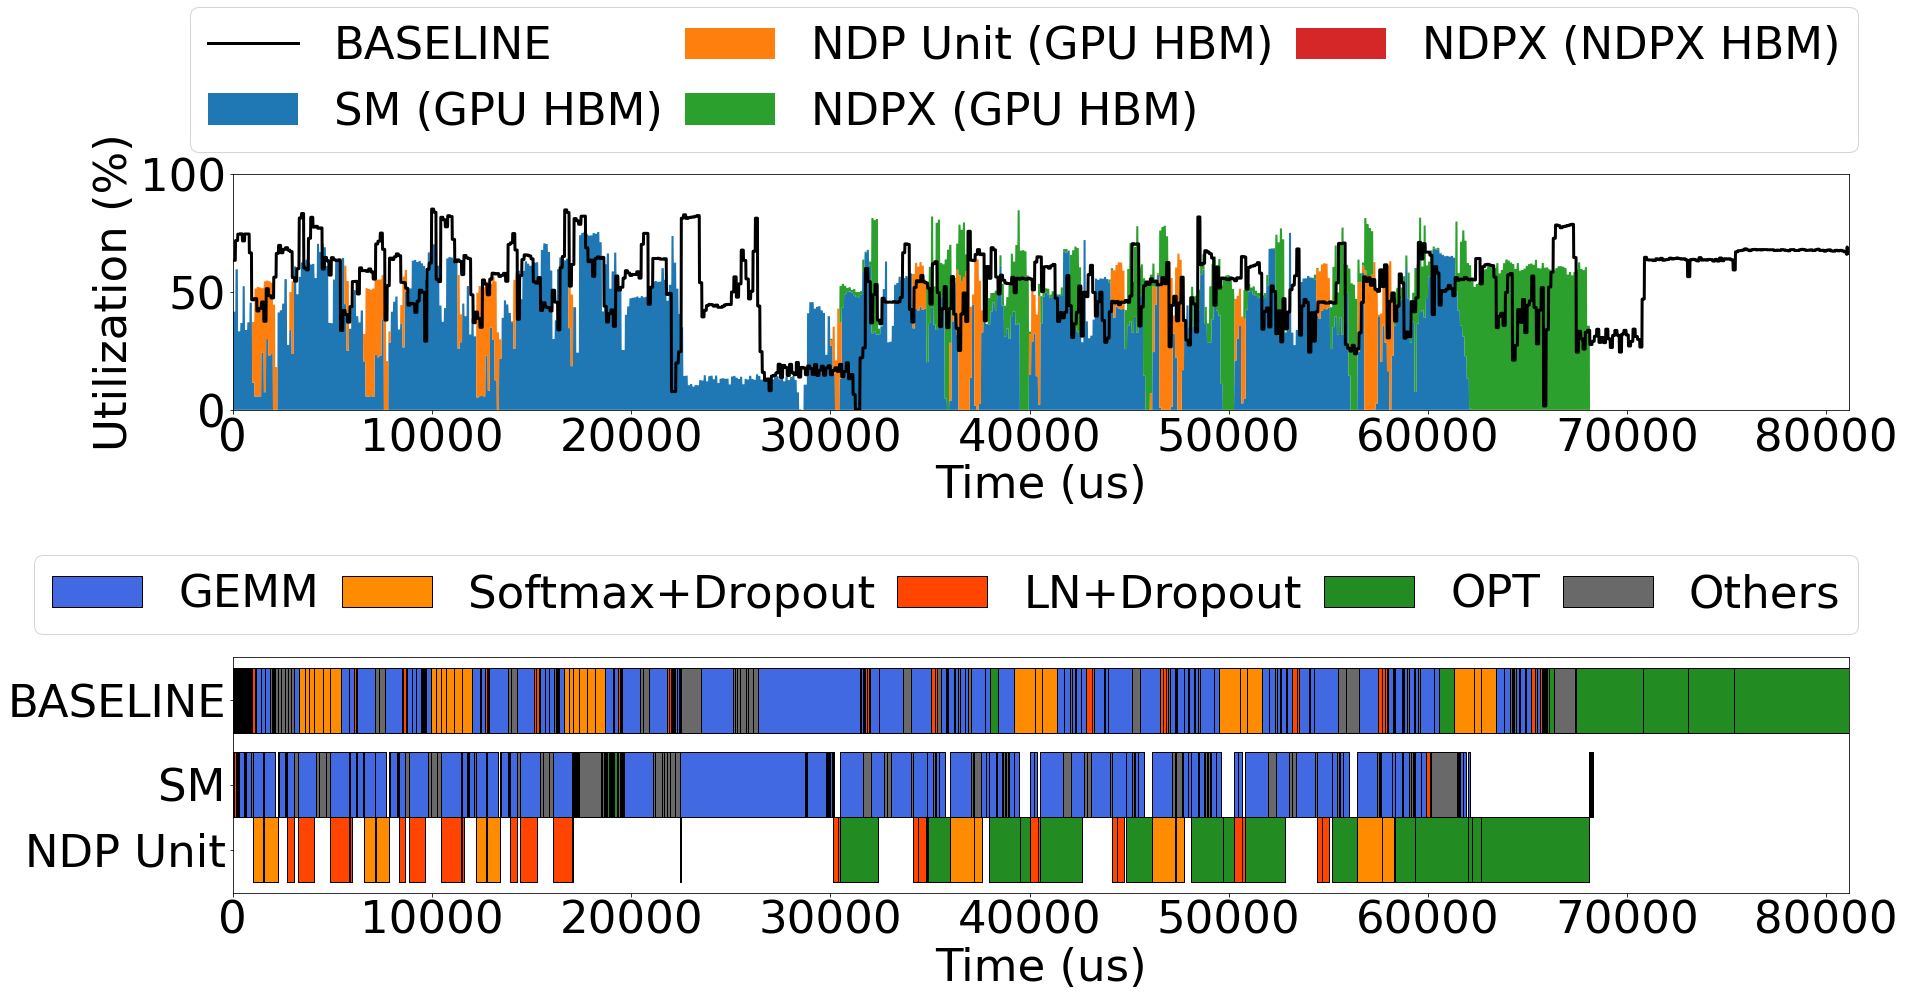

In [28]:
import matplotlib
dirs  = open(f'../../BERT_BASELINE/scripts/{MODEL}{BATCH}-dir.out')
# plt.rcParams["figure.figsize"] = (100,10)
offset = 0.0
BASE_MEM_Y = []
BASE_MEM_X = []
started_kernels_BASE = []
started_times_BASE = []
finished_times_BASE = []
plt.figure(figsize=(28,15))
matplotlib.rcParams.update({'font.size': 45, 'font.weight': 'medium'})
for dir in dirs.readlines():
    dir = dir.replace('\n', '')
#     util_file = open(f'{dir}/GPU_0_Port_0_UTIL.out')
#     ndpx_mem_file = open(f'{dir}/NDPX_MEM_ch_0_UTIL.out')
    gpu_mem_file = open(f'../../BERT_BASELINE/scripts/{dir}/GPU_MEM_ch_0_UTIL.out')

    # ndp_name = open(f'{dir}/NDP_name.out').readlines()[0].replace('\n', '')
    # TITLE = f'{dir.split("/")[-1]}-{ndp_name}'
    ID=dir.split("/")[-1]
    GPU2NDPX_list = []
    NDPX2GPU_list = []
    NDPX_MEM_list = []
    GPU_MEM_list = []
#     for line in util_file.readlines():
#         splited = line.split(' ')
#         GPU2NDPX = splited[8]
#         NDPX2GPU = splited[15]
#         GPU2NDPX_list.append(float(GPU2NDPX))
#         NDPX2GPU_list.append(float(NDPX2GPU))
#     for line in ndpx_mem_file.readlines():
#         splited = line.split(' ')
#         NDPX_MEM_list.append(float(splited[3]) / 100.0)
    for line in gpu_mem_file.readlines():
        try:
            splited = line.split(' ')
            GPU_MEM_list.append(float(splited[3]) / 100.0)   
        except:
            print(dir)
            print(splited)
    Link_X = range(0, len(GPU2NDPX_list))
    Link_X = list(map(lambda x: float(x) * PERIOD / LINK_FREQ + offset, Link_X))
    MEM_X = range(0, len(GPU_MEM_list))
    MEM_X = list(map(lambda x: float(x) * PERIOD / DRAM_FREQ + offset, MEM_X))
    BASE_MEM_Y+=(GPU_MEM_list)
    BASE_MEM_X+=(MEM_X)
    
    gantt_info = open(f'../../BERT_BASELINE/scripts/{dir}/Gantt.out', 'r')
    gantt_info_lines = gantt_info.readlines()
    gantt_info.close()
    for line in gantt_info_lines:
        words = line.split(' ')
  
        dev = words[5]
        if dev == 'NDP':
            kernel_name = group_NDP_kernel_name(words[8])
            cycle = (float(words[11]) / GPU_FREQ)  + offset
        else:
            kernel_name = group_GPU_kernel_name(words[7],   
                f'/home/shared/CXL_memory_buffer2/BERT_BASELINE/traces/{MODEL}{BATCH}/hlo_graph/{MODEL}{BATCH}.txt')
            cycle = (float(words[10]) / GPU_FREQ) + offset
        
        if words[4] == 'launched':
            started_kernels_BASE.append(kernel_name)
            started_times_BASE.append(cycle)
        else:
            finished_times_BASE.append(cycle)
    offset = finished_times_BASE[-1]
    
#     plt.plot(Link_X, GPU2NDPX_list, label='GPU to NDPX')
#     plt.plot(Link_X, NDPX2GPU_list, label='NDPX to GPU')
print(len(NDPX_MEM_X), len(BASE_MEM_X))

smooded_NDPX_MEM_Y = BW_averaging(NDPX_MEM_Y)
smooded_NDPX_MEM_Y2 = BW_averaging(NDPX_MEM_Y2)
smooded_NDPX_MEM_Y3 = BW_averaging(NDPX_MEM_Y3)
smooded_NDPX_MEM_Y4 = BW_averaging(NDPX_MEM_Y4)
smooded_BASE_MEM_Y = BW_averaging(BASE_MEM_Y)

# smooded_NDPX_MEM_Y = gaussian_filter1d(NDPX_MEM_Y, sigma=10)
# smooded_NDPX_MEM_Y2 = gaussian_filter1d(NDPX_MEM_Y2, sigma=10)
# smooded_NDPX_MEM_Y3 = gaussian_filter1d(NDPX_MEM_Y3, sigma=10)
# smooded_NDPX_MEM_Y4 = gaussian_filter1d(NDPX_MEM_Y4, sigma=10)
# smooded_BASE_MEM_Y = gaussian_filter1d(BASE_MEM_Y, sigma=10)


plt.tight_layout()
plt.subplot(2,1,1)
plt.stackplot(NDPX_MEM_X, smooded_NDPX_MEM_Y, smooded_NDPX_MEM_Y2, smooded_NDPX_MEM_Y3, smooded_NDPX_MEM_Y4, labels=['SM (GPU HBM)', 'NDP Unit (GPU HBM)', 'NDPX (GPU HBM)', 'NDPX (NDPX HBM)'])
plt.plot(BASE_MEM_X, smooded_BASE_MEM_Y, linewidth=3, color='k',label='BASELINE')
#     plt.plot(MEM_X, NDPX_MEM_list, label='NDPX memory util')
plt.legend(loc='lower right', ncol=3, bbox_to_anchor=(1.02, 1),  columnspacing=0.5)
# plt.ylim(0, 100)
plt.xlim(left=0, right=max(BASE_MEM_X))
plt.ylim(top=100)
plt.ylabel('Utilization (%)')
plt.xlabel('Time (us)')
# plt.title("UTIL")
# plt.axes().set_aspect(1/10)

plt.subplot(2,1,2)

GPU_DICT = dict()
NDP_DICT = dict()
NDPX_DICT = dict()
BASE_DICT = dict()

for name, start, end in zip(started_kernels_GPU, started_times_GPU, finished_times_GPU):
    if name not in GPU_DICT:
        GPU_DICT[name] = [(start, end - start)]
    else:
        GPU_DICT[name].append((start, end - start))
for name, start, end in zip(started_kernels_NDP, started_times_NDP, finished_times_NDP):    
    if name not in NDP_DICT:
        NDP_DICT[name] = [(start, end - start)]
    else:
        NDP_DICT[name].append((start, end - start))
for name, start, end in zip(started_kernels_NDPX, started_times_NDPX, finished_times_NDPX):    
    if name not in NDPX_DICT:
        NDPX_DICT[name] = [(start, end - start)]
    else:
        NDPX_DICT[name].append((start, end - start))

for name, start, end in zip(started_kernels_BASE, started_times_BASE, finished_times_BASE):
    if name not in BASE_DICT:
        BASE_DICT[name] = [(start, end - start)]
    else:
        BASE_DICT[name].append((start, end - start))



for name in GPU_DICT:
    if name == 'GEMM':
        plt.broken_barh(GPU_DICT[name],(2, 1), facecolors=color_map[name], edgecolor=colors['black'],label=name)
for name in GPU_DICT:
    if 'Softmax' in name:
        plt.broken_barh(GPU_DICT[name],(2, 1), facecolors=color_map[name], edgecolor=colors['black'],label=name)
for name in GPU_DICT:
    if 'LN' in name:
        plt.broken_barh(GPU_DICT[name],(2, 1), facecolors=color_map[name], edgecolor=colors['black'],label=name)
for name in GPU_DICT:
    if 'OPT' in name:
        plt.broken_barh(GPU_DICT[name],(2, 1), facecolors=color_map[name], edgecolor=colors['black'],label=name)
for name in GPU_DICT:
    if 'Others' in name:
        plt.broken_barh(GPU_DICT[name],(2, 1), facecolors=color_map[name], edgecolor=colors['black'],label=name)


for name in NDPX_DICT:
    print(NDPX_DICT[name])
    plt.broken_barh(NDPX_DICT[name],(1, 1), facecolors=color_map[name], edgecolor=colors['black'], label=name)

for name in NDP_DICT:
    plt.broken_barh(NDP_DICT[name],(1, 1), facecolors=color_map[name], edgecolor=colors['black'], label=name)

for name in BASE_DICT:
    plt.broken_barh(BASE_DICT[name],(3.3, 1), facecolors=color_map[name],edgecolor=colors['black'], label=name)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
val = by_label.values()
key = by_label.keys()
plt.xlim(left=0, right=max(BASE_MEM_X))
plt.yticks([1.5, 2.5, 3.8], labels=['NDP Unit', 'SM', 'BASELINE'])
plt.xlabel('Time (us)')
plt.legend(val, key, loc='lower right', ncol=5, bbox_to_anchor=(1.02, 1), columnspacing=0.5)
plt.tight_layout()
plt.savefig('Gantt_for_BERT_gpu_NDP_b3.pdf')
